### Using Age, Blood Pressure, Heart Rate, Cholesterol, and Fluoroscopy to Predict Heart Disease

### Introduction:

Heart disease (HD) encompasses heart conditions that affect heart function (Heart and Stroke Foundation of Canada, 2023). It is the second leading cause of death in Canada (Government of Canada, 2022). HD progression can be slowed through a healthy lifestyle if diagnosed early (Heart and Stroke Foundation of Canada, 2023).

**In our data set, the columns are:**

- Patient’s age (years)

- Patient’s sex

- Chest pain type (typical angina, atypical angina, non-anginal pain, asymptomatic)

- Resting blood pressure (mmHg)

- Cholesterol levels (mg/dL)

- Fasting blood sugar (above/below 120mg/dL)

- Resting electrocardiographic results (normal, ST-T wave abnormality, ventricular hypertrophy)

- Maximum heart rate (bpm)

- Exercise-induced angina occurred

- Depression of the ST segment on an ECG from exercise

- Slope of the peak ST segment from exercise (upslope, flat, downslope)

- Number of major arteries coloured by fluoroscopy (0-3)

- Thalassemia status (normal, fixed defect, reversible defect)

- Heart disease diagnosis (called hd for short)


Research question: **based on a patient’s characteristics, what is their likely HD diagnosis?**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
set.seed(50)
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
    #rename the columns
    rename("age"= X1, "sex" = X2, "chest_pain" = X3, "trestbps" = X4, "chol" = X5, "fasting_bs" = X6, "restecg" = X7, "max_heart_rate" = X8, "exang" = X9, "old_peak" = X10, "peak_slope" = X11, "ca" = X12, "thal" = X13, "predicted" = X14) |>
    #change the "sex" column observations from binary to "male" and "female"
    mutate(sex = recode(sex, "1" = "male", "0" = "female")) |>
    #change the "chest_pain" column from numeric to their given chest pain types.
    mutate(chest_pain = recode(chest_pain, "1" = "typical_angina", "2" = "atypical_angina", "3" = "non_anginal_pain", "4" = "asymptomatic")) |>
    #change restbps from dbl to in
    mutate(restbps = as.integer(trestbps)) |>
    #change cholesterol from dgl to int
    mutate(chol = as.integer(chol)) |>
    #change fasting blood sugar from binary to their given meanings
    mutate(fasting_bs = recode(fasting_bs, "1" = "over_120", "0" = "under_120")) |>
    #change the restecg from numeric to its given value meanings
    mutate(restecg = recode(restecg, "0" = "normal", "1" = "abnormal", "2" = "hypertrophy")) |>
    #change max_heart_rate from dbl to int
    mutate(max_heart_rate = as.integer(max_heart_rate)) |>
    #ensures is a dbl
    mutate(old_peak = as.numeric(old_peak)) |>
    #ensures the fluoroscopu data is an integer rather than a numeric value
    mutate(fluoro = as.integer(ca)) |>
    #changes values from binary to their given value meanings
    mutate(exang = recode(exang, "0" = "no", "1" = "yes")) |>
    #ensures the slope values are numeric
    mutate(peak_slope = as.integer(peak_slope)) |>
    #ensures the defect status has its given name rather than numbers associated with them
    mutate(thal = recode(thal, "3.0" = "normal", "6.0" = "fixed_defect", "7.0" = "reversable_defect")) |>
    #predicted is the HD diagnosis we wish to determine, therefore we turn it into a factor
    mutate(predicted = as.factor(predicted)) |>
    #Giving the numeric observations their given meanings.
    mutate(predicted = recode(predicted, "0" = "no_hd", "1" = "hd", "2" = "hd", "3" = "hd", "4" = "hd"))

#now that we have all of the data from the dataset labelled in a meaningful way, we select those relevant to our question.
heart_data_select <- heart_data |> select(age,restbps, chol, max_heart_rate, fluoro, predicted)
  
heart_data_select

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,no_hd
67,160,286,108,3,hd
67,120,229,129,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1,hd
57,130,236,174,1,hd
38,138,175,173,NA,no_hd


### Tablature Analysis: 

To begin our exploratory data analysis, we began by counting the quantity of NA values that the dataset contains. 

In [3]:
heart_data_select |> summarise(Num_Of_NA = sum(is.na(heart_data_select)))

Num_Of_NA
<int>
4


As we can see there are NA entries in our data.
Let us remove them.

In [4]:
heart_data_select <- heart_data_select |>
    na.omit()
heart_data_select

age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,no_hd
67,160,286,108,3,hd
67,120,229,129,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
68,144,193,141,2,hd
57,130,131,115,1,hd
57,130,236,174,1,hd


In [5]:
#creating our training and testing data sets
heart_split <- initial_split(heart_data_select, prop = 0.75, strata = predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
67,160,286,108,3,hd
67,120,229,129,2,hd
62,140,268,160,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
56,130,221,163,0,no_hd
55,132,342,166,0,no_hd
41,120,157,182,0,no_hd


Let us see how many total observations we have:

In [6]:
nrow(heart_train)

[1] 223

Now let us see how many of these have heart disease and how many do not.

In [7]:
heart_train |> count(predicted)

predicted,n
<fct>,<int>
no_hd,120
hd,103


This table displays the most affected category/mean for each variable which are most prone to getting heart disease in our dataset.

In [8]:
heart_train |> group_by(predicted) |>
#we select each column that we wish to summarize with a different computation.
    summarise(Mean_Affected_Age = mean(age),
          Average_Resting_BPS = mean(restbps),
          Average_Chol = mean(chol),
          Avg_Maximum_Heart_rate_Recorded = mean(max_heart_rate),
        Avg_fluoroscopy_count = mean(fluoro))

predicted,Mean_Affected_Age,Average_Resting_BPS,Average_Chol,Avg_Maximum_Heart_rate_Recorded,Avg_fluoroscopy_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no_hd,52.30000,128.1417,244.1000,159.2833,0.350000
hd,56.53398,135.5825,256.6796,138.4563,1.165049


This table shows higher average age, resting blood pressure, cholesterol, and fluoroscopy highlights but lower average heart rate for those with HD than without.

### Visualization Analysis:

To explore our training data, we began by plotting proportion of HD diagnoses against age.

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


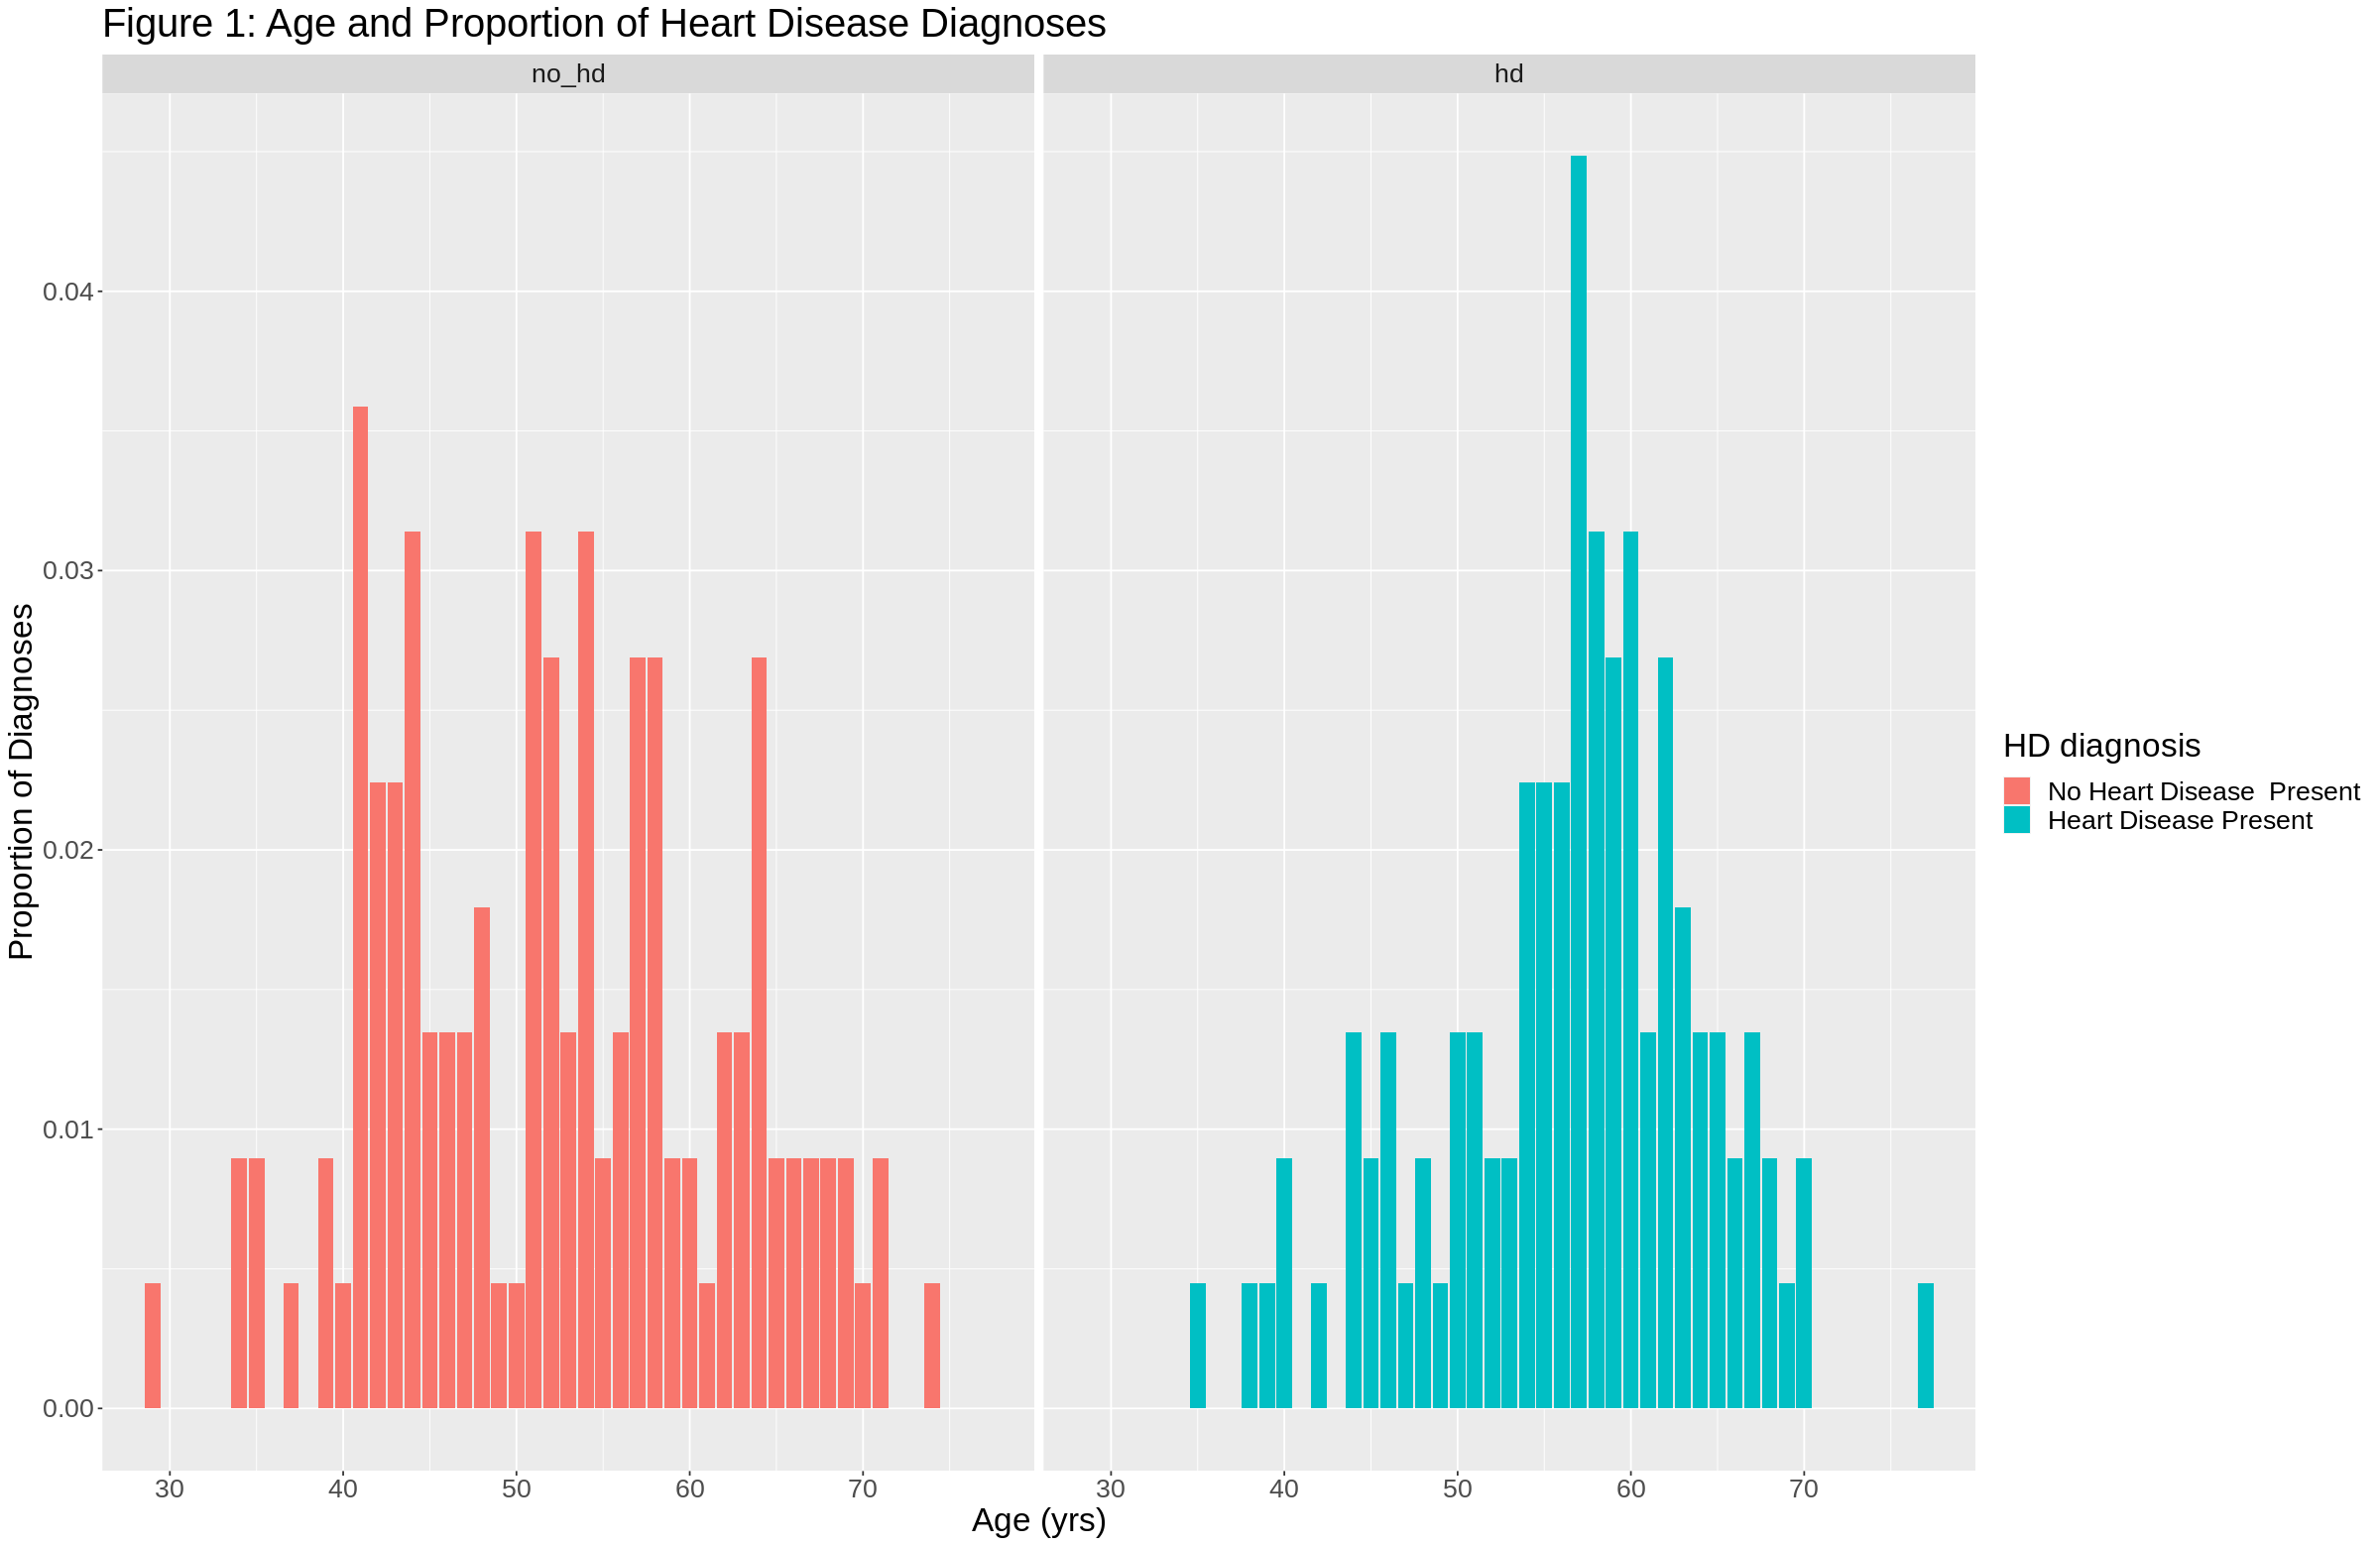

In [9]:
options(repr.plot.width = 20, repr.plot.height = 13) 
#count the total number of rows in the training data set.
total_rows <- nrow(heart_train)

#create a table with only the ages and their counts for each HD diagnosis type.
hd_age_count <- heart_train |>
    group_by(age, predicted) |>
    summarize(count = n()/total_rows)

#create the viz.
hd_age_plot <- hd_age_count |>
    ggplot(aes(x = age, y = count, fill = predicted)) +
    geom_bar(stat = "identity") +
    labs(x = "Age (yrs)", y = "Proportion of Diagnoses") +
    labs(fill = "HD diagnosis")+
    scale_fill_discrete(labels = c("No Heart Disease  Present", "Heart Disease Present")) +
    ggtitle("Figure 1: Age and Proportion of Heart Disease Diagnoses") + 
    facet_grid(cols = vars(predicted)) +
    theme(text = element_text(size = 20))

hd_age_plot

A significant proportion of patients with HD are around 60 but the age is more evenly distributed for patients without HD. 

Next, the cholesterol levels count should be observed as high cholesterol levels are linked to heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



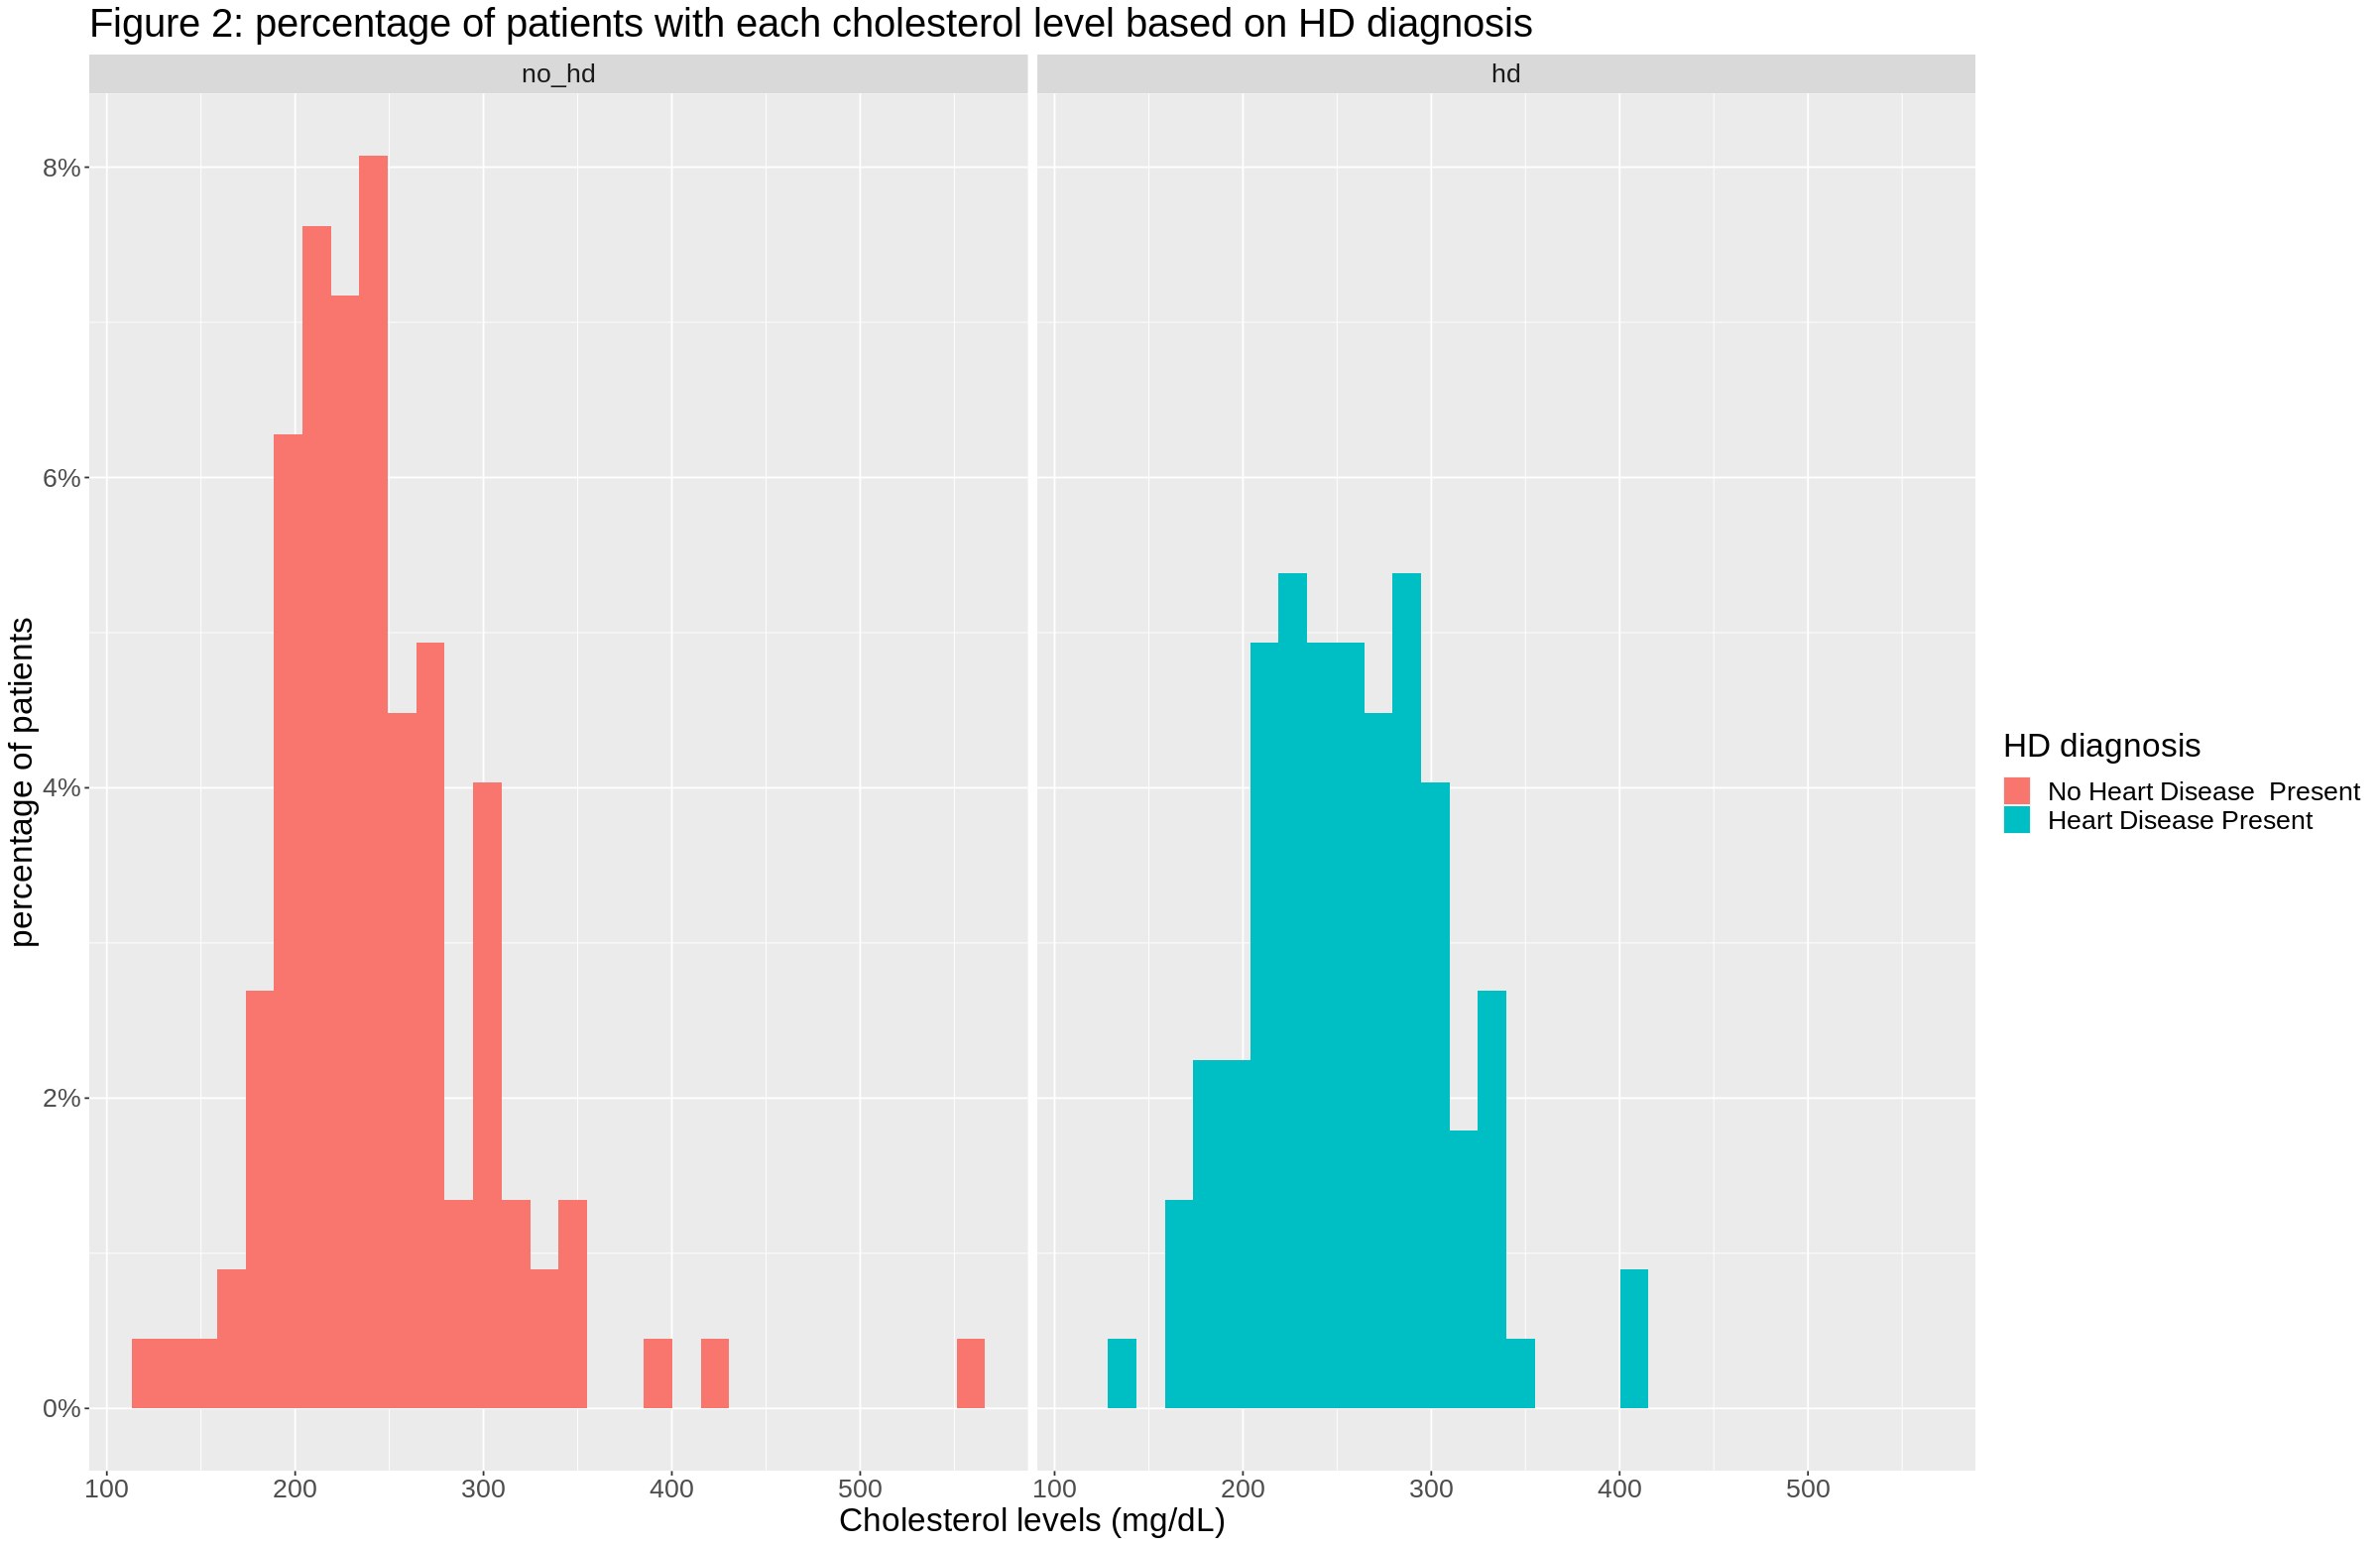

In [10]:
#create a plot comparing cholesterol levels with the percentage of patients in that level.
chol_plot<- heart_train|>
#cholesterol in the x-axis
    ggplot(aes(x=chol))+
#write the proportion for the y-axis rather than simply the count.
    geom_histogram(aes(y = (..count..)/sum(..count..), fill = predicted)) +
  scale_y_continuous(labels=percent)+
    facet_grid(cols = vars(predicted))+
    labs(x = "Cholesterol levels (mg/dL)", y = "percentage of patients") +
    labs(fill = "HD diagnosis")+
    scale_fill_discrete(labels = c("No Heart Disease  Present", "Heart Disease Present")) +
    ggtitle("Figure 2: percentage of patients with each cholesterol level based on HD diagnosis") + 
    theme(text = element_text(size = 20))
    
chol_plot

Patients with HD are shown to have a median cholesterol level slightly higher than those without.

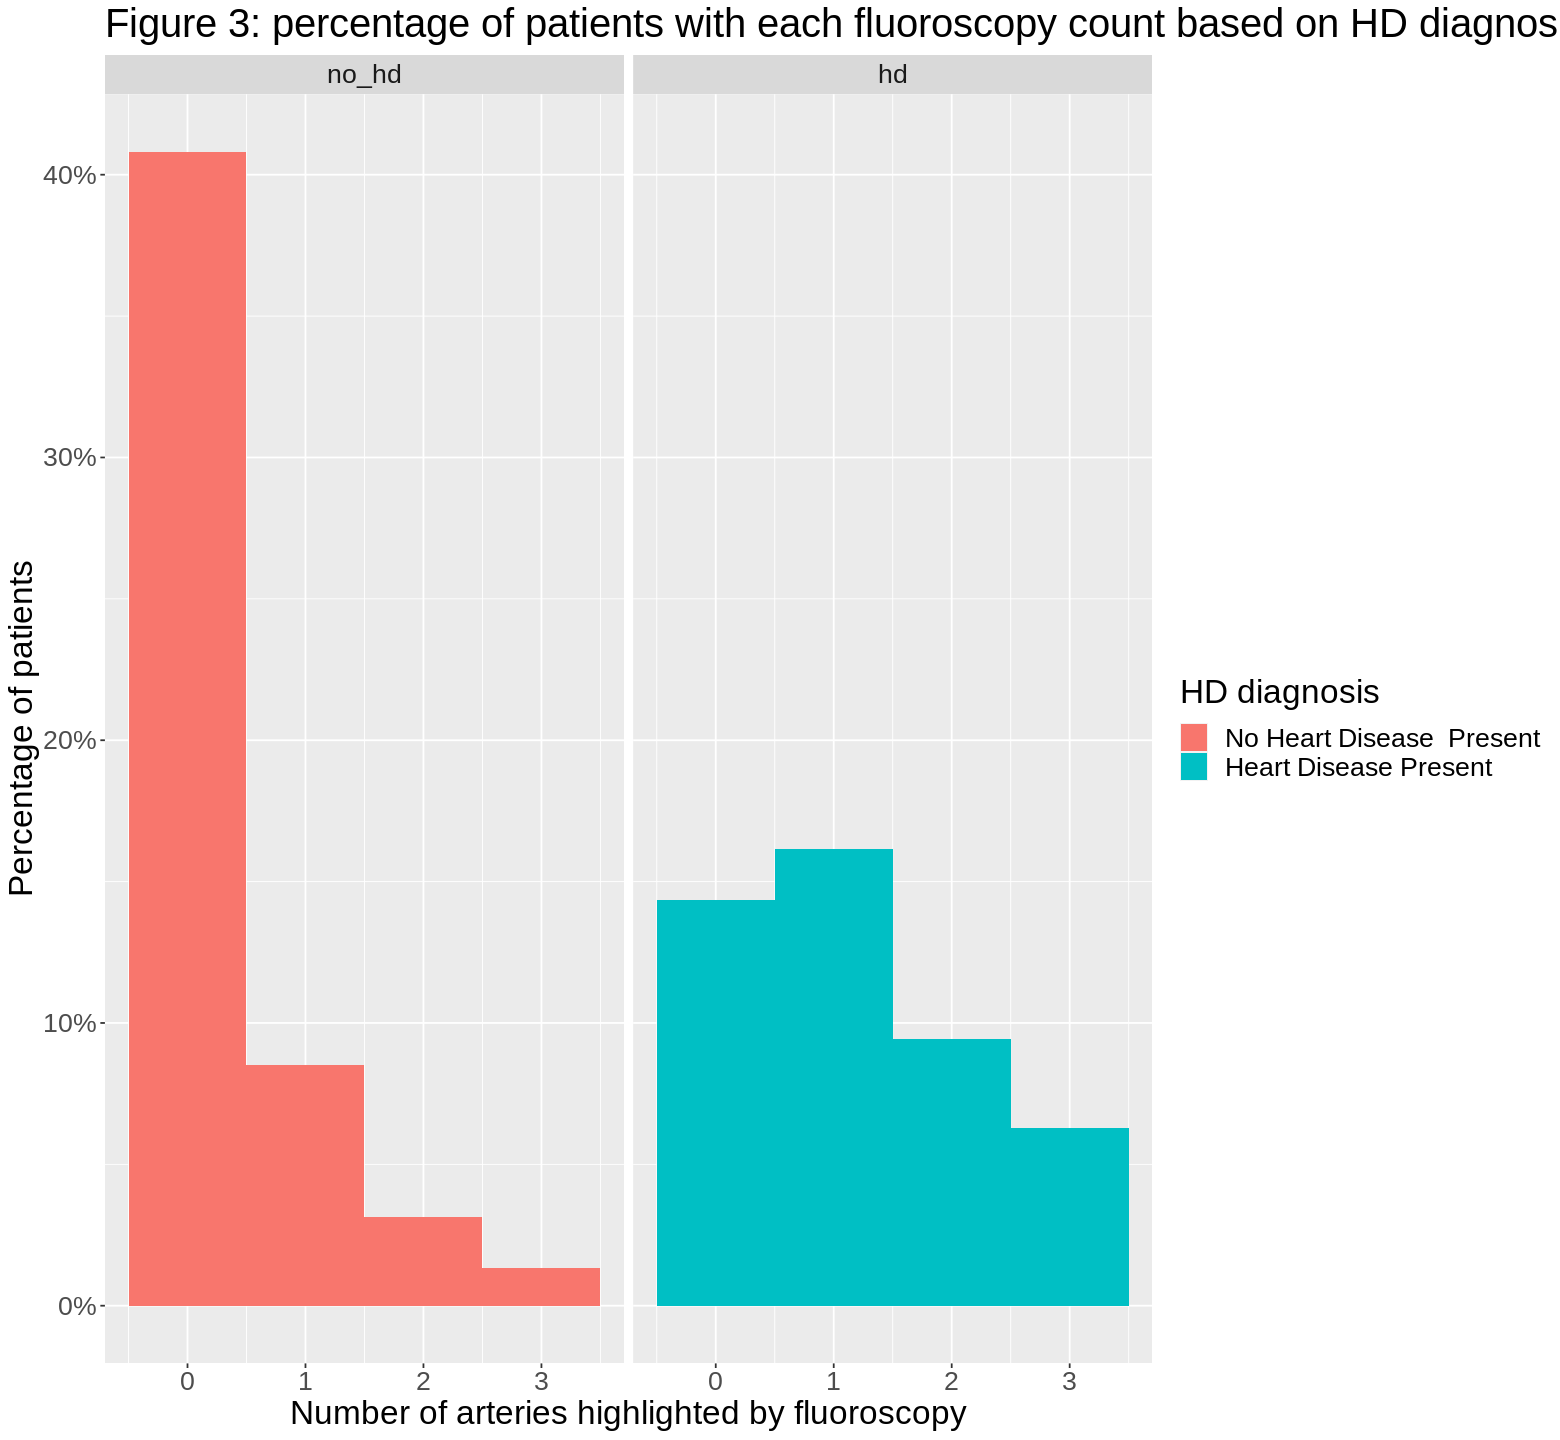

In [11]:
options(repr.plot.width = 13, repr.plot.height = 12)
#create a plot comparing the fluoroscopy counts with the proportion of patients exhibiting it.
fluoro_plot<- heart_train|>
#have fluoroscopy counts in the x-axis
    ggplot(aes(x=fluoro))+
#ensure the y-axis displays percentage rather than simply the total counts.
    geom_histogram(bins = 4, (aes(y = (..count..)/sum(..count..), fill = predicted))) +
  scale_y_continuous(labels=percent)+
    facet_grid(cols = vars(predicted))+
    labs(x = "Number of arteries highlighted by fluoroscopy", y = "Percentage of patients") +
    labs(fill = "HD diagnosis")+
    scale_fill_discrete(labels = c("No Heart Disease  Present", "Heart Disease Present")) +
    ggtitle("Figure 3: percentage of patients with each fluoroscopy count based on HD diagnosis") + 
    theme(text = element_text(size = 20))

fluoro_plot

Patients without HD have fewer arteries highlighted by fluoroscopy as they function normally, compared to patients with HD. A majority of HD patients have one or more arteries highlighted by fluroscopy. 

### Methods:

1) We begin by splitting the dataset into training and testing datasets. The analysis will be done using K-nearest neighbor classification using predictor variables variables including age, resting blood pressure, exercising heart rate, cholesterol level, and fluoroscopy.

    We picked the age variable because as age increases, a person’s risk of heart disease may increase (National Institutes of Health, 2018). Studies show that high blood pressure is a common symptom of heart disease (American Heart Association, 2022). Similarly, same correlations can be seen with heart rate (Perret-Guillaume et al., 2009) and cholesterol level (Heart and Stroke Foundation of Canada, 2023). Fluoroscopy is used to see the blood flow in arteries, which is an indicator of artery blockage that can help doctors diagnose heart disease (Johns Hopkins Medicine, 2019).




2) Use the vfold_cv function to split up the training data for cross-validation.

3) Create a recipe that specifies the class label and predictors, as well as preprocessing steps for all variables then pass the training data as the data argument of the recipe.

4) Create a nearest_neighbors model specification with neighbors = tune().

5) Add the recipe and model specification to a workflow() and use the tune_grid function on the train/validation splits to estimate the classifier accuracy for a range of K values.

6) Pick a value of K that yields a high accuracy estimate that doesn’t change much if you change K to a nearby value.

    In this case, we can see that **K = 13**.

7) Make a new model specification for the best parameter value (i.e. K = 13), and retrain the classifier using the fit function.

8) Evaluate the estimated accuracy of the classifier on the test set using the predict function.


In [12]:
heart_recipe <- recipe(predicted ~ fluoro + max_heart_rate + chol + restbps + age, data = heart_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

#cross validation (10 folds)
folds <- heart_train |> vfold_cv(v = 10, strata = predicted) 

grid_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    tune_grid(resamples = folds, grid = grid_vals) |>
    collect_metrics()

accuracies <- heart_results |>
  filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6411067,10,0.03031907,Preprocessor1_Model01
4,accuracy,binary,0.7316206,10,0.02742189,Preprocessor1_Model02
7,accuracy,binary,0.7266798,10,0.03049297,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
94,accuracy,binary,0.7223320,10,0.02616577,Preprocessor1_Model32
97,accuracy,binary,0.7270751,10,0.02967419,Preprocessor1_Model33
100,accuracy,binary,0.7270751,10,0.03172667,Preprocessor1_Model34


The table above represents the results of a 10-fold cross validation on our algorithm. With this information, we can create a plot of each k value and its corresponding accuaracy.

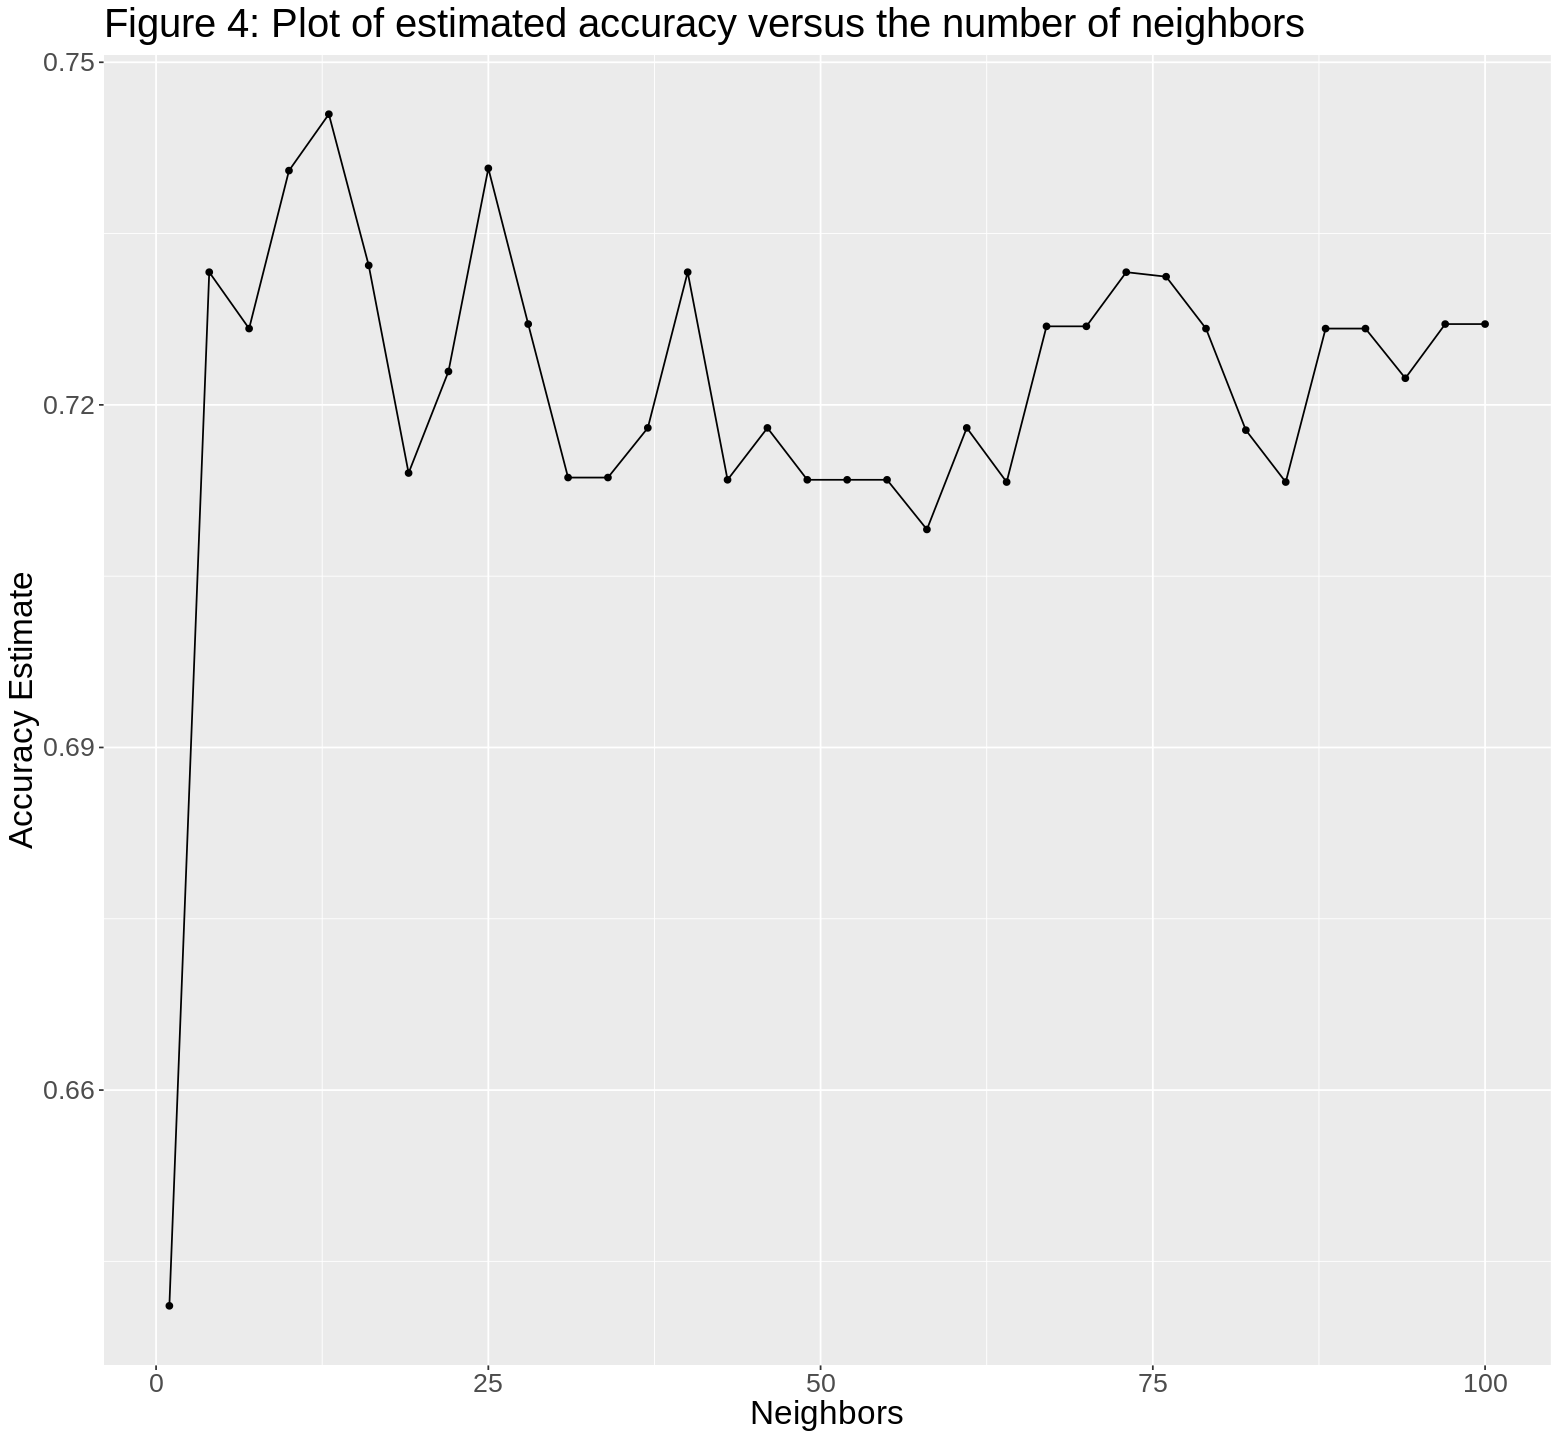

In [13]:
cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate",title = "Figure 4: Plot of estimated accuracy versus the number of neighbors") +
    theme(text = element_text(size = 20))
cross_val_plot

The difference between the accuracy of each K value changes sporadically. The potential reason for the relationship observed in Figure 4 will be explained in the Discussion section.

In [14]:
max_acc <- accuracies |> select(neighbors,mean) |> arrange(desc(mean)) |> slice(1)
max_acc

neighbors,mean
<dbl>,<dbl>
13,0.7454545


Our most accurate K value is 13!

In [15]:
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_best_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(best_k_spec) |>
  fit(data = heart_train)

heart_best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2690583
Best kernel: rectangular
Best k: 13

Using our most accurate K value which is 13, we can test how proficient our algorithm is at classifying heart disease.

In [16]:
heart_test_predictions <- predict(heart_best_fit, heart_test) |>
  bind_cols(heart_test)

heart_test_predictions

.pred_class,age,restbps,chol,max_heart_rate,fluoro,predicted
<fct>,<dbl>,<int>,<int>,<int>,<int>,<fct>
no_hd,49,130,266,171,0,no_hd
hd,58,132,224,173,2,hd
no_hd,50,120,219,158,0,no_hd
⋮,⋮,⋮,⋮,⋮,⋮,⋮
no_hd,67,152,212,150,0,hd
no_hd,63,124,197,136,0,hd
hd,59,164,176,90,2,hd


In [17]:
heart_test_predictions |>
  metrics(truth = predicted, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7763158


Our classifier has an accuracy of about 77.63% when the k-value is set to 13 

In [18]:
confusion <- heart_test_predictions |>
             conf_mat(truth = predicted, estimate = .pred_class)
confusion

          Truth
Prediction no_hd hd
     no_hd    35 11
     hd        6 24

According to the confusion matrix, our algorithim mainly diagnosed patients as heart disease free, when in reality the patient had heart disease. The classification error is similar to a false-negative diagnosis. The algorithim did not often diagnose patients with heart disease despite not having heart disease. This error is similar to a false-positive diagnosis.

### Result:

We observed by utilizing a 10-fold cross validation method, the number of nearest neighbors (K) giving us the best accuracy is **K = 13**

Then by creating a model specification using K = 13, we predicted heart diseases with an accuracy of about **77.63%**.

### Discussion

**Summary**

Through knn classification methods, we created an algorithm that can diagnose heart disease based on a patient’s age, blood pressure, cholesterol, fluoroscopy and heart rate. By performing a 10-fold cross-validation, we found our algorithm could predict heart disease diagnoses based on predictors at an accuracy of nearly 77.63%. 

With many predictors and a smaller training set of 223 observations, our accuracy vs k value graph (Figure 4) depicted many drastic changes in the accuracy of every third k value. The visualization may indicate that the algorithm is highly dependent on the selected k value. The variance between each K value indicates that the number of neighbours selected is critical in developing a strong classification algorithm. With the incorrect k value, the classification algorithm will be considerably weaker. Irrelevant predictors are unlikely to be driving the erratic relationship in Figure 4 as each variable is empirically proven to contribute to the existence of heart disease. The sporadic relationship may be caused by our large number of predictors and a proportionately low number of observations.

With a seed value of 50, k = 13 provides an 77.63% accuracy which we believe is acceptable considering the large number of predictors and a limited quantity of observations. We can likely assume that a seed exists with a higher accuracy if the testing and training split is perfectly optimized. A larger quantity of patient data would create stronger predictions as more observations in the dataset will increase the proportion of training and testing data for the algorithm to use. The higher quantity of observations will also increase the algorithm’s classification proficiency by introducing more instances for the algorithm to learn from.  

With a 77.63% accuaracy, our classifier can predict heart disease at an acceptable rate given the correct predictors, but incorrect classification can be dangerous in a practical setting. Our confusion matrix displays classification error leading to false-positive diagnosis and false-negative diagnosis. If our classifier is used practically for heart disease diagnosis, a false-positive diagnosis would lead to significant negative consequences for the patient who would assume they have a life-threatening disease. 

**Discuss whether this is what you expected to find?**

We expected to produce a prediction model for the heart disease diagnosis based on age, cholesterol, blood pressure, fluoroscopy and heart rate. We expected it to show that older patients with higher cholesterol, higher blood pressure, more arteries highlighted by fluoroscopy, and lower maximum heart rates will likely be diagnosed with heart disease.

Given the common knowledge that, at minimum, age and blood pressure are strong indicators of heart disease; we expected the model to be relatively accurate. Our prediction model predicted heart diseases with an accuracy of 77.63%, which in our opinion is good considering the real world application of predicting heart diseases using these predictors. Given that this is a prediction relevant to a patient’s health, an ideally usable model would be more accurate. However, given the limited number of observations available to train the data, a good prediction can be made. There are many other factors which may lead to heart disease that may not be in the data or were not used in our model, and could have been used to create a more accurate model.

**Discuss what impact could such findings have?**

Since we were able to determine a patient’s heart disease status somewhat accurately, this shows that preliminary suggestions towards a patient’s heart disease status are possible using data classification. This could open the door for classification to be used as a useful tool to predict a patient’s heart disease status in the medical field.  Furthermore, this could lead to classification being used to predict conditions in other patients in other fields other than cardiology. For example, neurologists and immunologists can probably use data classification to give preliminary suggestions towards a patient’s conditions in their respective fields. 


In the field of medicine, the system of classification could be a cheaper alternative to extensive testing. Patients could also potentially receive a preliminary diagnosis of their condition from home using a simple program from their mobile phones or personal computers.


Similarly to the field of medicine, data analysis and data classification could be extended to other fields, if it isn’t already being used in those fields. In the field of quantum mechanics in chemistry or physics, with particles being superimposed, scientists could use data to predict which shells electrons could be in, for example. In short,  we can expect to see more machine learning and algorithms in the future than we see today. 


**Discuss what future questions could this lead to?**

This could lead to the investigation of the various factors against each other to see if there is a relation between one and the other. For example, blood pressure is related to cholesterol levels, and the predictive capabilities between the two could be investigated.

This project has shown a moderate reliability in the predictability of heart disease. As such, it opens a door for new research questions to be developed to improve this model specifically, and also other potential uses of classification predictions in a medical context:

This model only used 5 predictors to predict the patient’s heart disease status. What other relevant predictors could be included or replace current ones to predict heart disease more accurately? This project is limited by the factors observed in the dataset; however other, more relevant, symptoms may be useful to increase the accuracy of the model.

Can the less invasive predictors be used to predict the results of other factors that could be observed with more invasive procedures. For example, can cholesterol and age predict the number of vessels highlighted by fluoroscopy? If a reliable model can be produced, it would reduce the need for such an invasive procedure to be used.

In this project, we combined male and female patients as one. Does the sex of the patient also affect the likelihood of their heart disease diagnosis?

Could this model be applied to other diseases? Can these same predictors help diagnose other heart issues, and different predictors diagnose other diseases altogether?


**References**

American Heart Association. (2022, March 4). Health threats from high blood pressure. www.heart.org. Retrieved March 2, 2023, from https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure#:~:text=Angina%20%E2%80%94%20Over%20time%2C%20high%20blood,head%2C%20causing%20pain%20or%20fatigue.

Canada, P. H. A. of. (2022, July 28). Government of Canada. Canada.ca. Retrieved March 2, 2023, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html 

Heart and Stroke Foundation of Canada. (2023). Managing cholesterol. Heart and Stroke Foundation of Canada. Retrieved March 2, 2023, from https://www.heartandstroke.ca/heart-disease/risk-and-prevention/condition-risk-factors/managing-cholesterol 

Heart and Stroke Foundation of Canada. (2023). Types of heart disease. Heart and Stroke Foundation of Canada. Retrieved March 2, 2023, from https://www.heartandstroke.ca/heart-disease/what-is-heart-disease/types-of-heart-disease 


Johns Hopkins Medicine. (2019, August 14). Fluoroscopy procedure. Fluoroscopy Procedure | Johns Hopkins Medicine. Retrieved March 2, 2023, from https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/fluoroscopy-procedure#:~:text=Fluoroscopy%20is%20a%20study%20of,can%20be%20seen%20in%20detail 

National Institutes of Health. (2018). Heart health and aging. National Institute on Aging. Retrieved March 2, 2023, from https://www.nia.nih.gov/health/heart-health-and-aging#changes 

NHS. (2020). Coronary heart disease - Diagnosis - NHS. NHS choices. Retrieved March 2, 2023, from https://www.nhs.uk/conditions/coronary-heart-disease/diagnosis/ 

Perret-Guillaume, C., Joly, L., & Benetos, A. (2009). Heart rate as a risk factor for cardiovascular disease. Progress in Cardiovascular Diseases, 52(1), 6–10. https://doi.org/10.1016/j.pcad.2009.05.003 